### Import the necessary libraries

In [1]:
# import here
import os
import PIL
import pickle
#import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import torch.utils.data.sampler as sampler
from torch import nn, optim
import torch.nn.functional as F
from torchvision.utils import save_image

/apps/conda/bbadjie/envs/bbadjie-base/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Preparations 

In [2]:
# Define the path to the dataset directory
#dataset_dir = "/home/bbadjie/Defensive-Distillation-as-an-Adversarial-Roustness-Algorithm/traffic-signs-data/"

# Load pickled data
training_file = "traffic-signs-data/train.p"
validation_file = "traffic-signs-data/valid.p"
testing_file = "traffic-signs-data/test.p"
perturb_file = "traffic-signs-data/perturbed_images.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

with open(perturb_file, mode='rb') as f:
    perturb = pickle.load(f)


X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']
X_perturb, y_perturb = perturb[0], perturb[0]


X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_valid.shape, y_valid.shape, len(X_perturb), len(y_perturb)

((34799, 32, 32, 3),
 (12630, 32, 32, 3),
 (34799,),
 (12630,),
 (4410, 32, 32, 3),
 (4410,),
 34799,
 34799)

In [3]:
class PickledDataset(Dataset):
    def __init__(self, file_path, transform=None):
        with open(file_path, mode='rb') as f:
            data = pickle.load(f)
            self.features = data['features']
            self.labels = data['labels']
            self.count = len(self.labels)
            self.transform = transform
        
    def __getitem__(self, index):
        feature = self.features[index]
        if self.transform is not None:
            feature = self.transform(feature)
        return (feature, self.labels[index])

    def __len__(self):
        return self.count

In [4]:
class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

In [5]:
class PickledDatasetP(Dataset):
    def __init__(self, file_path, transform=None):
        with open(file_path, mode='rb') as f:
            data = pickle.load(f)
            self.features = data[0]
            self.labels = data[1]
            self.count = len(self.labels)
        self.transform = transform


In [6]:
train_dataset = PickledDataset(training_file, transform=transforms.ToTensor())
valid_dataset = PickledDataset(validation_file, transform=transforms.ToTensor())
test_dataset = PickledDataset(testing_file, transform=transforms.ToTensor())
perturb_dataset = PickledDatasetP(perturb_file, transform=transforms.ToTensor())

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
perturb_loader = DataLoader(perturb_dataset, batch_size=64, shuffle=False)



In [7]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
perturb_loader = DataLoader(perturb_dataset, batch_size=64, shuffle=False)


#### Define the Denoising Autoencoder model

In [8]:
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Define the model, criterion, optimizer and the training loop
model = DenoisingAutoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

### We will define the training function, which will train the model on the given data for a given number of epochs

In [9]:
def train(model, optimizer, criterion, train_loader, valid_loader, epochs):
    train_losses = []
    valid_losses = []

    for epoch in range(epochs):
        train_loss = 0.0
        valid_loss = 0.0

        # Training
        model.train()
        for data in train_loader:
            optimizer.zero_grad()
            noisy_data, clean_data = data
            noisy_data = noisy_data.float().cuda()
            clean_data = clean_data.float().cuda()
            output = model(noisy_data)
            loss = criterion(output, clean_data)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * noisy_data.size(0)
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        with torch.no_grad():
            for data in valid_loader:
                noisy_data, clean_data = data
                noisy_data = noisy_data.float().cuda()
                clean_data = clean_data.float().cuda()
                output = model(noisy_data)
                loss = criterion(output, clean_data)
                valid_loss += loss.item() * noisy_data.size(0)
            valid_loss /= len(valid_loader.dataset)
            valid_losses.append(valid_loss)

        print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Valid Loss: {valid_loss:.4f}")

    return train_losses, valid_losses


#### Here we will define the function to test the model on the given data and calculate the reconstruction error.

In [10]:

def test(model, criterion, test_loader):
    test_loss = 0.0
    with torch.no_grad():
        for data in test_loader:
            noisy_data, clean_data = data
            noisy_data = noisy_data.float().cuda()
            clean_data = clean_data.float().cuda()
            output = model(noisy_data)
            loss = criterion(output, clean_data)
            test_loss += loss.item() * noisy_data.size(0)
    test_loss /= len(test_loader.dataset)
    print(f"Test Loss: {test_loss:.4f}")

    return test_loss

def reconstruction_error(model, criterion, perturb_loader):
    recon_loss = 0.0
    with torch.no_grad():
        for data in perturb_loader:
            perturbed_data, clean_data = data
            perturbed_data = perturbed_data.float().cuda()
            clean_data = clean_data.float().cuda()
            output = model(perturbed_data)
            loss = criterion(output, clean_data)
            recon_loss += loss.item() * perturbed_data.size(0)
    recon_loss /= len(perturb_loader.dataset)
    print(f"Reconstruction Error: {recon_loss:.4f}")

    return recon_loss


#### Train and save the model

Using device: cuda
Epoch [1/100] | Train Loss: 0.0592 | Valid Loss: 0.0266
Epoch [2/100] | Train Loss: 0.0211 | Valid Loss: 0.0198
Epoch [3/100] | Train Loss: 0.0174 | Valid Loss: 0.0175
Epoch [4/100] | Train Loss: 0.0159 | Valid Loss: 0.0163
Epoch [5/100] | Train Loss: 0.0149 | Valid Loss: 0.0155
Epoch [6/100] | Train Loss: 0.0142 | Valid Loss: 0.0148
Epoch [7/100] | Train Loss: 0.0135 | Valid Loss: 0.0141
Epoch [8/100] | Train Loss: 0.0130 | Valid Loss: 0.0136
Epoch [9/100] | Train Loss: 0.0126 | Valid Loss: 0.0133
Epoch [10/100] | Train Loss: 0.0123 | Valid Loss: 0.0130
Epoch [11/100] | Train Loss: 0.0121 | Valid Loss: 0.0128
Epoch [12/100] | Train Loss: 0.0119 | Valid Loss: 0.0127
Epoch [13/100] | Train Loss: 0.0118 | Valid Loss: 0.0125
Epoch [14/100] | Train Loss: 0.0117 | Valid Loss: 0.0124
Epoch [15/100] | Train Loss: 0.0116 | Valid Loss: 0.0123
Epoch [16/100] | Train Loss: 0.0115 | Valid Loss: 0.0122
Epoch [17/100] | Train Loss: 0.0114 | Valid Loss: 0.0121
Epoch [18/100] | Trai

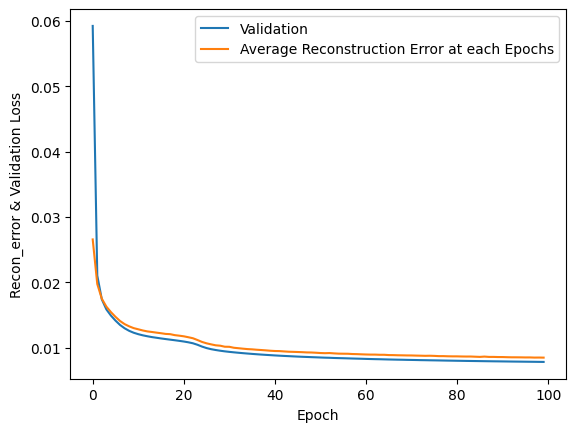

In [16]:
import matplotlib.pyplot as plt

# Set the device to be used for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the model, criterion, optimizer and the training loop
model = DenoisingAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 100
train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    train_loss = 0
    valid_loss = 0

    # Training
    model.train()
    for data in train_loader:
        img, _ = data
        img = img.to(device)
        noisy_img = img + torch.randn(img.size(), device=device) * 0.12  # add Gaussian noise
        noisy_img = torch.clamp(noisy_img, 0, 1)  # clip values to [0,1]

        optimizer.zero_grad()
        outputs = model(noisy_img)
        loss = criterion(outputs, img)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Validation
    model.eval()
    with torch.no_grad():
        for data in valid_loader:
            img, _ = data
            img = img.to(device)
            noisy_img = img + torch.randn(img.size(), device=device) * 0.12
            noisy_img = torch.clamp(noisy_img, 0, 1)

            outputs = model(noisy_img)
            #loss = criterion(outputs, img)
            recon_error = criterion(outputs, img)

            valid_loss += recon_error.item()

    # Print the losses
    train_loss /= len(train_loader)
    valid_loss /= len(valid_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {train_loss:.4f} | Valid Loss: {valid_loss:.4f}")
    
    # Append the losses to lists
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    # Save a few reconstructed images
    if epoch == 0 or epoch == num_epochs-1:
        img_grid = torch.cat((noisy_img.cpu(), outputs.cpu(), img.cpu()), dim=3)
        save_image(img_grid, f"reconstructed_images_{epoch+1}.png")

# Save the trained model
torch.save(model.state_dict(), "denoising_autoencoder.pth")

# Plot the losses
plt.plot(range(num_epochs), train_losses, label="Validation")
plt.plot(range(num_epochs), valid_losses, label="Average Reconstruction Error at each Epochs")
plt.xlabel("Epoch")
plt.ylabel("Recon_error & Validation Loss")
plt.legend()
plt.show()


#### Test the model on the test set and save the reconstructed images and reconstruction error

In [12]:
# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the test set and loader
#test_dataset = ImageDataset('test_images', transform=transform)
#test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Load the trained model
model = DenoisingAutoencoder()
model.load_state_dict(torch.load('denoising_autoencoder.pth'))
model.to(device)

# Set the model to evaluation mode
model.eval()

# Initialize the reconstruction error
test_loss = 0

# Generate the reconstructed images and calculate the reconstruction error
with torch.no_grad():
    for data in test_loader:
        images, _ = data
        images = images.to(device)
        reconstructed = model(images)
        test_loss += criterion(reconstructed, images).item() * images.size(0)
        save_image(reconstructed, 'traffic-signs-data/{}.png'.format(data[1][0]), normalize=True)



# Calculate the average reconstruction error
test_loss /= len(test_loader.dataset)

# Print the test loss
print('Reconstruction_Error: {:.6f}'.format(test_loss))


Reconstruction_Error: 0.008190


In [13]:
reconstructed = model(images)
save_image(reconstructed, 'traffic-signs-data/{}.png'.format(data[1][0]), normalize=True)
reconstructed_images = reconstructed.detach().cuda()
print(reconstructed_images.shape)

torch.Size([22, 3, 32, 32])


In [15]:
reconstructed_images = []
count = 0
for images, _ in test_loader:
    images = images.to(device)
    reconstructed = model(images)
    for i in range(images.size(0)):
        save_image(reconstructed[i], 'traffic-signs-data/{}.png'.format(count), normalize=True)
        reconstructed_images.append(reconstructed[i])
        count += 1

In [16]:
# combine the list of reconstructed images into a single tensor
reconstructed_images_tensor = torch.stack(reconstructed_images)

# print the shape of the tensor
print(reconstructed_images_tensor.shape)

torch.Size([12630, 3, 32, 32])


# DEFENSIVE DISTILLATION

#### Define the teacher model

In [81]:
import torch.nn as nn
import torchvision.models as models

teacher_model = models.resnet18(pretrained=True)
num_features = teacher_model.fc.in_features
teacher_model.fc = nn.Linear(num_features, 43)


/apps/conda/bbadjie/envs/bbadjie-base/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/apps/conda/bbadjie/envs/bbadjie-base/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/bbadjie/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:04<00:00, 11.4MB/s]


#### Train the teacher_model

In [122]:

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(teacher_model.parameters(), lr=0.001)

best_val_loss = float('inf')

num_epochs = 100

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
teacher_model.to(device)

for epoch in range(num_epochs):
    train_loss = 0.0
    valid_loss = 0.0
    teacher_model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        data, target = data.to(device), target.to(device)
        output = teacher_model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
    train_loss = train_loss/len(train_loader.dataset)
    
    teacher_model.eval()
    for data, target in valid_loader:
        data, target = data.to(device), target.to(device)
        output = teacher_model(data)
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)
    valid_loss = valid_loss/len(valid_loader.dataset)

    if valid_loss < best_val_loss:
        best_val_loss = valid_loss
        torch.save(teacher_model.state_dict(), 'teacher_model.pth')

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
    epoch+1, train_loss, valid_loss))    

Epoch: 1 	Training Loss: 0.005732 	Validation Loss: 0.177513
Epoch: 2 	Training Loss: 0.032140 	Validation Loss: 0.326152
Epoch: 3 	Training Loss: 0.004219 	Validation Loss: 0.237763
Epoch: 4 	Training Loss: 0.003840 	Validation Loss: 0.274413
Epoch: 5 	Training Loss: 0.020836 	Validation Loss: 0.470922
Epoch: 6 	Training Loss: 0.040638 	Validation Loss: 0.331881
Epoch: 7 	Training Loss: 0.011610 	Validation Loss: 0.429296
Epoch: 8 	Training Loss: 0.019511 	Validation Loss: 0.305067
Epoch: 9 	Training Loss: 0.032248 	Validation Loss: 0.207645
Epoch: 10 	Training Loss: 0.020700 	Validation Loss: 0.328377
Epoch: 11 	Training Loss: 0.006030 	Validation Loss: 0.343239
Epoch: 12 	Training Loss: 0.003356 	Validation Loss: 0.236125
Epoch: 13 	Training Loss: 0.003737 	Validation Loss: 0.243996
Epoch: 14 	Training Loss: 0.004304 	Validation Loss: 0.280218
Epoch: 15 	Training Loss: 0.003876 	Validation Loss: 0.232024
Epoch: 16 	Training Loss: 0.000583 	Validation Loss: 0.286183
Epoch: 17 	Traini

#### Evaluate the teacher model and generate soft labels

In [123]:

teacher_model.eval()
soft_labels = []
with torch.no_grad():
    for data, target in train_loader:
        data = data.to(device)
        output = teacher_model(data)
        soft_labels.append(output.softmax(dim=1))
soft_labels = torch.cat(soft_labels, dim=0)



#### Let's implement the train function that returns the training and validation losses and accuracies at each epoch:

In [124]:

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # ensure the weight tensor is on the same device as the input tensor
        model_weight = next(model.parameters()).to(inputs.device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)
    return epoch_loss, epoch_acc.item()


def validate(model, dataloader, criterion, device):
    model.eval()
    valid_loss = 0.0
    valid_acc = 0.0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            valid_acc += torch.sum(preds == labels.data)
    epoch_loss = valid_loss / len(dataloader.dataset)
    epoch_acc = valid_acc / len(dataloader.dataset)
    return epoch_loss, epoch_acc


#### Let's plot the training and validation losses and accuracies, by modifying the main training loop to call these functions and store the results:

In [126]:
import matplotlib as plt
train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

for epoch in range(num_epochs):
    train_loss, train_acc = train(teacher_model, train_loader, criterion, optimizer, device)
    valid_loss, valid_acc = validate(teacher_model, valid_loader, criterion, device)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {valid_loss:.4f}, Val Acc: {valid_acc:.4f}')




Epoch 1/100, Train Loss: 0.0011, Train Acc: 0.9996, Val Loss: 0.2788, Val Acc: 0.9603
Epoch 2/100, Train Loss: 0.0004, Train Acc: 0.9999, Val Loss: 0.2568, Val Acc: 0.9599
Epoch 3/100, Train Loss: 0.0003, Train Acc: 0.9999, Val Loss: 0.2677, Val Acc: 0.9583
Epoch 4/100, Train Loss: 0.0050, Train Acc: 0.9989, Val Loss: 0.2285, Val Acc: 0.9605
Epoch 5/100, Train Loss: 0.0008, Train Acc: 0.9998, Val Loss: 0.2566, Val Acc: 0.9590
Epoch 6/100, Train Loss: 0.0011, Train Acc: 0.9998, Val Loss: 0.2897, Val Acc: 0.9526
Epoch 7/100, Train Loss: 0.0007, Train Acc: 0.9998, Val Loss: 0.2361, Val Acc: 0.9596
Epoch 8/100, Train Loss: 0.0008, Train Acc: 0.9998, Val Loss: 0.2051, Val Acc: 0.9680
Epoch 9/100, Train Loss: 0.0074, Train Acc: 0.9991, Val Loss: 0.2416, Val Acc: 0.9540
Epoch 10/100, Train Loss: 0.0043, Train Acc: 0.9992, Val Loss: 0.2676, Val Acc: 0.9574
Epoch 11/100, Train Loss: 0.0012, Train Acc: 0.9997, Val Loss: 0.2026, Val Acc: 0.9644
Epoch 12/100, Train Loss: 0.0006, Train Acc: 0.9999,

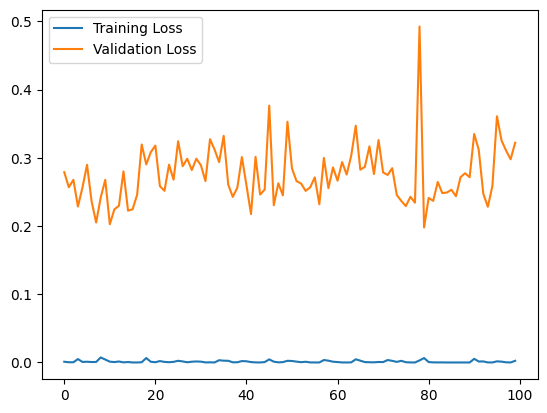

In [143]:
# plot the results
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.legend()
plt.show()

# plt.plot(train_accs, label='Training Accuracy')
# plt.plot(valid_accs, label='Validation Accuracy')
# plt.legend()
# plt.show()




#### Define the Student model

In [158]:
import torch.nn as nn

class StudentNet(nn.Module):
    def __init__(self):
        super(StudentNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(800, 120)
        self.fc2 = nn.Linear(120, 43)

    def forward(self, x):
        x = self.pool1(nn.functional.relu(self.conv1(x)))
        x = self.pool2(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 800)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x


#### Train the student model

In [174]:
import torch.optim as optim

batch_size = 64
num_epochs = 60

# Define the student model
student_model = StudentNet()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
student_model.to(device)

# Define the optimizer
optimizer = optim.SGD(student_model.parameters(), lr=0.01, momentum=0.9)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define a function to evaluate the model on a validation set
def test_func(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            running_loss += loss.item() * data.size(0)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    accuracy = 100. * correct / total
    loss = running_loss / len(dataloader.dataset)
    return loss, accuracy

# Train the student model
for epoch in range(num_epochs):
    # Set the model to training mode
    student_model.train()

    # Train for one epoch
    for batch_idx, (data, target) in enumerate(train_loader):
        # Transfer the data to GPU, if available
        data, target = data.to(device), target.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        output = student_model(data)

        # Calculate the loss
        loss = criterion(output, soft_labels[batch_idx * batch_size : (batch_idx + 1) * batch_size])

        # Backward pass
        loss.backward()

        # Update the parameters
        optimizer.step()

    # Evaluate the model on the validation set
    valid_loss, valid_accuracy = test_func(student_model, valid_loader, criterion)

    # Print the epoch and validation metrics
    print('Epoch: {:02d} \tValidation Loss: {:.4f} \tValidation Accuracy: {:.4f}'.format(
          epoch, valid_loss, valid_accuracy))


# Define a dictionary to store the results
results = {'loss': [], 'accuracy': []}

# Train the model
for epoch in range(num_epochs):
    train_loss, train_accuracy = train(student_model, train_loader, criterion, optimizer, device)
    valid_loss, valid_accuracy = test_func(student_model, valid_loader, criterion)

    # Store the results in the dictionary
    results['loss'].append(valid_loss)
    results['accuracy'].append(valid_accuracy)

    # Print the epoch and validation metrics
    print('Epoch: {:02d} \tValidation Loss: {:.4f} \tValidation Accuracy: {:.4f}'.format(
          epoch, valid_loss, valid_accuracy))

# Access the results using square brackets, not parentheses
print('Final Validation Loss: {:.4f} \tFinal Validation Accuracy: {:.4f}'.format(
      results['loss'][-1], results['accuracy'][-1]))


Epoch: 00 	Validation Loss: 3.5669 	Validation Accuracy: 5.4422
Epoch: 01 	Validation Loss: 3.5561 	Validation Accuracy: 5.4422
Epoch: 02 	Validation Loss: 3.5551 	Validation Accuracy: 5.4422
Epoch: 03 	Validation Loss: 3.5556 	Validation Accuracy: 5.4422
Epoch: 04 	Validation Loss: 3.5550 	Validation Accuracy: 5.4422
Epoch: 05 	Validation Loss: 3.5541 	Validation Accuracy: 5.4422
Epoch: 06 	Validation Loss: 3.5533 	Validation Accuracy: 5.4422
Epoch: 07 	Validation Loss: 3.5532 	Validation Accuracy: 5.4422
Epoch: 08 	Validation Loss: 3.5530 	Validation Accuracy: 5.4422
Epoch: 09 	Validation Loss: 3.5527 	Validation Accuracy: 5.4422
Epoch: 10 	Validation Loss: 3.5527 	Validation Accuracy: 5.4422
Epoch: 11 	Validation Loss: 3.5523 	Validation Accuracy: 5.4422
Epoch: 12 	Validation Loss: 3.5522 	Validation Accuracy: 5.4422
Epoch: 13 	Validation Loss: 3.5521 	Validation Accuracy: 5.4422
Epoch: 14 	Validation Loss: 3.5521 	Validation Accuracy: 5.4422
Epoch: 15 	Validation Loss: 3.5522 	Vali

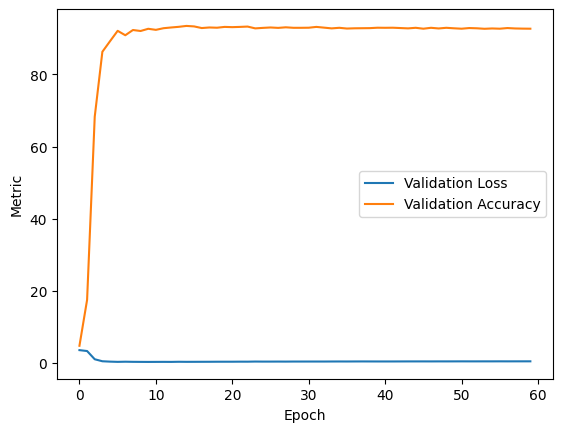

In [176]:
# Plot the validation loss and accuracy
plt.plot(results['loss'], label='Validation Loss')
plt.plot(results['accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()
plt.show()